## Sentiment Based Product Recommendation System

In this Notebook we are going to develop a sentiment based recommendation system, it has two parts 

- __Data Sourcing & Sentiment Analysis__
- __Building a Recommendation System__

#### Process Followed: 
- Data Sourcing, cleaning, text processing, validate multiple models and select one final Sentiment Model
- Create and analyse User-based & Item-based recommendation system. Select one final Recommendation System. 
- Saved pickle files for models and helpers like vectorizer
- Integrated the model data flow and deployed in Heroku. 

Heroku URL: https://capstone-sentiment.herokuapp.com


*Submission By : Vinod Mukundan*  
*Date: 12 - April - 2021*

In [1]:
#Add all imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold,cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from imblearn.metrics import sensitivity_specificity_support
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from wordcloud import WordCloud, STOPWORDS
from numpy import mean
import joblib

pd.set_option('display.max_columns', 150)
mpl.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

### Load Values

In [2]:
#Read the input files.
data = pd.read_csv("sample30.csv", encoding='ISO-8859-1', low_memory=False)
data.head(10)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,False,1,My boyfriend and I bought this to spice things...,Not worth it,NaN,NaN,samantha,Negative
6,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-08T00:00:00.000Z,False,False,1,Bought this earlier today and was excited to c...,Disappointing,NaN,NaN,raeanne,Negative
7,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-21T00:00:00.000Z,False,False,1,I bought this product for my husband and I to ...,Not happy at all,NaN,NaN,kimmie,Negative
8,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-28T00:00:00.000Z,False,False,1,My husband and I bought this for some extra fu...,Very disappointing,NaN,NaN,cassie,Negative
9,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-21T00:00:00.000Z,False,False,1,Got as a surprise for my husband there is noth...,Don't buy,NaN,NaN,moore222,Positive


In [3]:
data.shape

(30000, 15)

### Data Processing

As per the live sessions, its more advantageous to use both review title and text to infer the sentiment. This will make our model more effective. 


In [4]:
data['review_title_text'] = data['reviews_title'].map(str) + ' ' + data['reviews_text'].map(str)

In [5]:
# Let us only take the columns that are required, this will help in speeding up the process. 
useful_list = ['id','name','reviews_rating','user_sentiment', 'review_title_text']
data = data[useful_list]
data.head()

,id,name,reviews_rating,user_sentiment,review_title_text
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,Positive,Just Awesome i love this album. it's very good...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Positive,Good Good flavor. This review was collected as...
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Positive,Good Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,Negative,Disappointed I read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,Negative,Irritation My husband bought this gel for us. ...


In [6]:
# let us check if the data has any null values. 
data.isnull().sum()

id                   0
name                 0
reviews_rating       0
user_sentiment       1
review_title_text    0
dtype: int64

In [7]:
# There is only one row having user sentiment as null. Lets see the data.
data[data["user_sentiment"].isnull()]

,id,name,reviews_rating,user_sentiment,review_title_text
28354,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,5,NaN,a super hit with my children. they loved it!!?...


The data shows that the reviews rating is 5. So we are gonna change this null with Positive. If we had more data will null then we would have to come up with a different logic like comparing similar products or just based on ratings if present.

In [8]:
data["user_sentiment"].fillna("Positive", inplace = True)

In [9]:
# Confirm no null values.
data.isnull().sum()

id                   0
name                 0
reviews_rating       0
user_sentiment       0
review_title_text    0
dtype: int64

__Check if the data is balanced or not with respect to our target variable user sentiment__

In [10]:
round(data['user_sentiment'].value_counts(normalize=True)*100, 2)

Positive    88.78
Negative    11.22
Name: user_sentiment, dtype: float64

Data is highly skewed, before the model building we will have to handle this __class imbalance__ 

### EDA 

Lets do some exploratiry analysis on data to understand it better. 

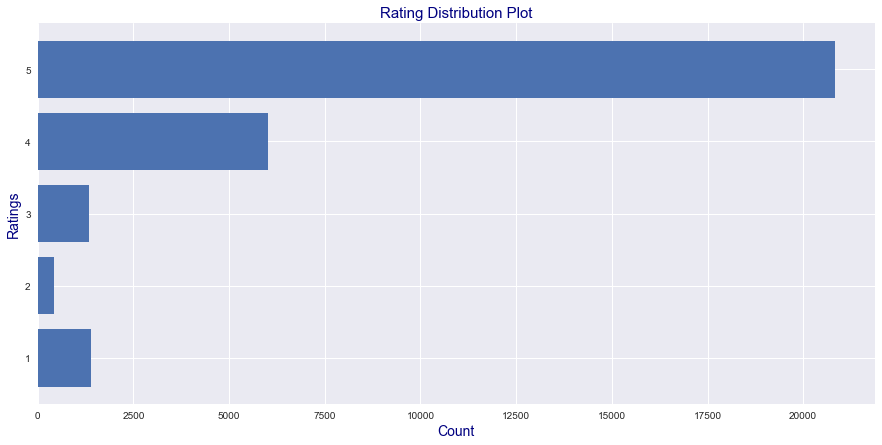

In [11]:
# Plot the reviews_rating with its count.
plt.figure(0, figsize=(15,7))
x = list(data['reviews_rating'].value_counts().index)
y = list(data['reviews_rating'].value_counts())
plt.barh(x, y)
plt.title('Rating Distribution Plot' , fontsize=15, color="navy")
plt.ylabel("Ratings", fontsize=14, color="navy")
plt.xlabel("Count", fontsize=14, color="navy")
plt.show()

**Observations:**
    
    - Looks like we have loads of 5 star rating, the products seems well liked. 
    - We got around ~60K 4 start rating, the least count is for rating 2. 

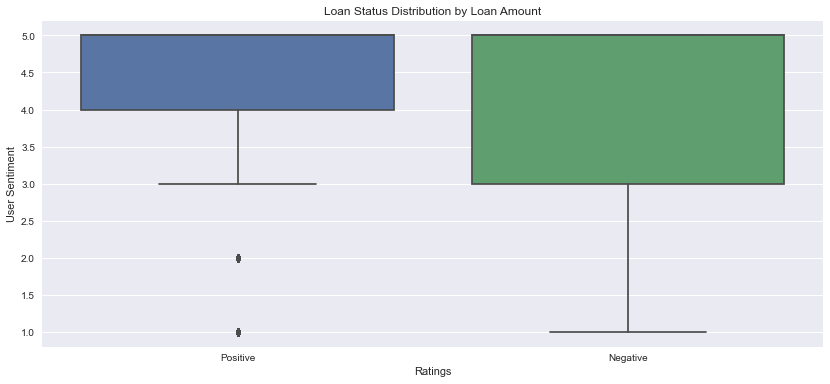

In [12]:
# Box Plot to see the user sentiment and reviews rating. 
plt.figure(figsize=(14, 6))
sns.boxplot(x="user_sentiment", y="reviews_rating", data=data)
plt.xlabel('Ratings')
plt.ylabel('User Sentiment')
plt.title('Loan Status Distribution by Loan Amount')
plt.show()

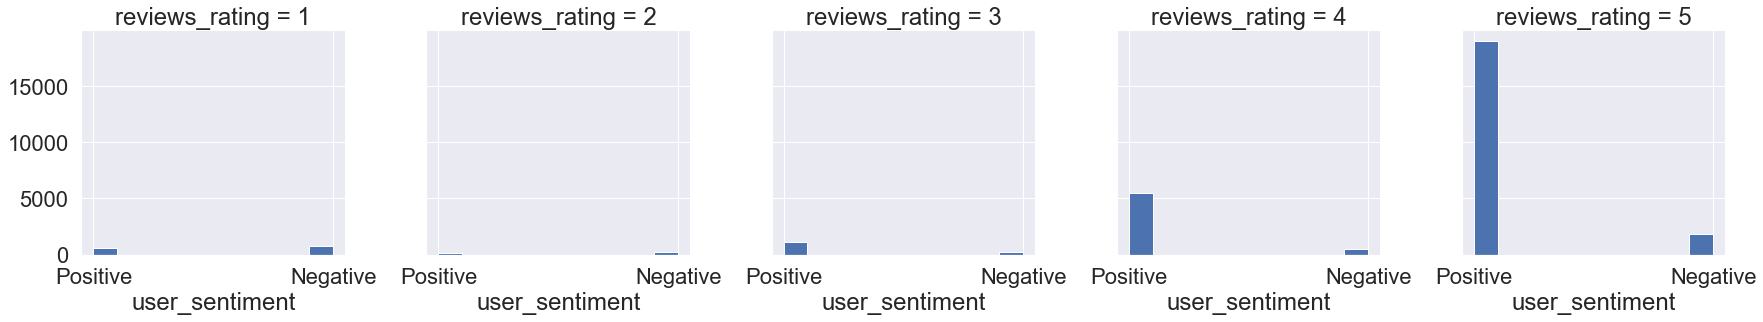

In [13]:
# Facet grid to plot to confirm relation between sentiment and rating. 
sns.set(font_scale=2.0)
g = sns.FacetGrid(data,col='reviews_rating',height=5)
g.map(plt.hist,'user_sentiment')
plt.show()

**Observations:**
    
    - Above 3 plots are in expected lines, apart from few anomolies the data looks valid. 

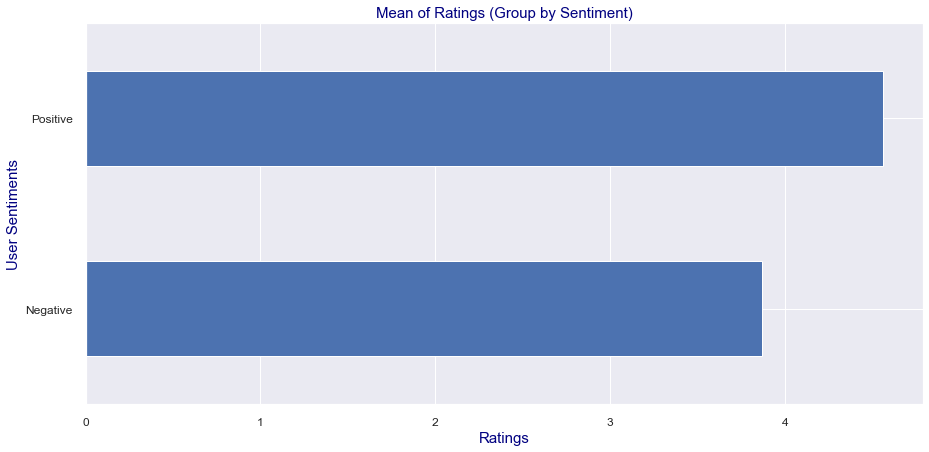

In [14]:
# User sentiment mean and ratings. 
plt.figure(0, figsize=(15,7))
df = data.groupby(['user_sentiment'])['reviews_rating'].mean()
ax = df.plot(kind='barh', fontsize=12);
ax.set_title("Mean of Ratings (Group by Sentiment)",  fontsize=15, color="navy")
ax.set_xlabel("Ratings", fontsize=15, color="navy");
ax.set_ylabel("User Sentiments", fontsize=15, color="navy");
plt.show()

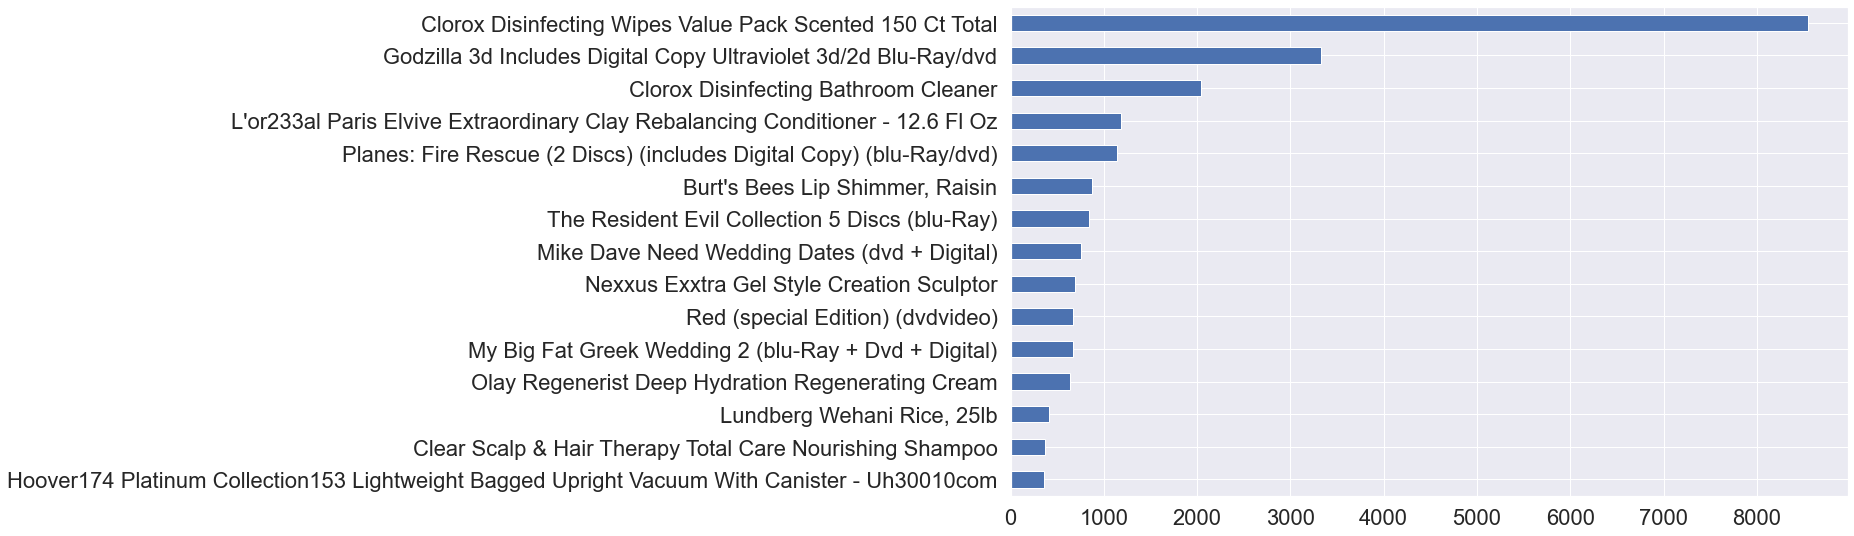

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                        8545
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                                  3325
Clorox Disinfecting Bathroom Cleaner                                                             2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz                   1186
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                              1143
Burt's Bees Lip Shimmer, Raisin                                                                   873
The Resident Evil Collection 5 Discs (blu-Ray)                                                    845
Mike Dave Need Wedding Dates (dvd + Digital)                                                      757
Nexxus Exxtra Gel Style Creation Sculptor                                                         693
Red (special Edition) (dvdvideo)                                                  

In [15]:
# Let us see the top 15 most rated products.
dfName = data['name'].value_counts()[0:15]
plt.figure(0, figsize=(15,9))
p1 = dfName.plot(kind='barh').invert_yaxis()
plt.show()
print(dfName)

**Let us plot and see the word count frequeny**

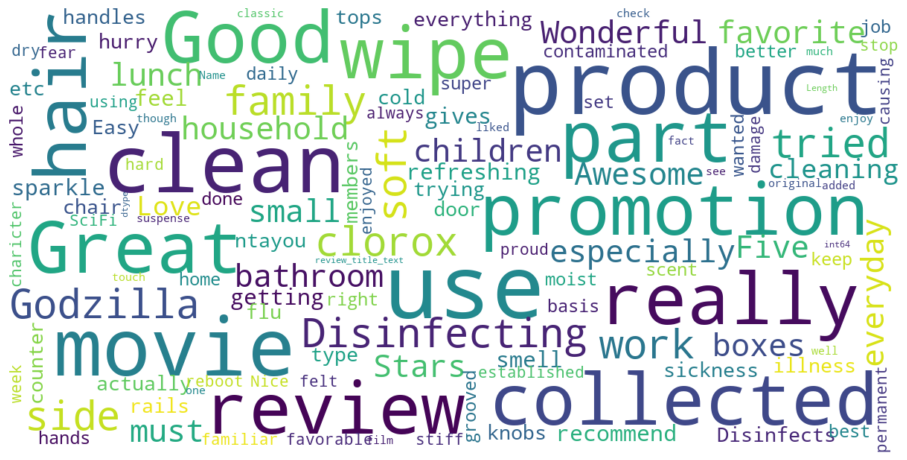

In [16]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=1000, max_font_size=40,
                     scale=3, random_state=1).generate(str(data['review_title_text'].value_counts()))
plt.figure(figsize=(16,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Observations:**

    - WordCount is on expected likes, the review contains product names, the usual suspects like good, great, love etc.

**Lets convert user sentiment to binary data, easier to handle and process. It is optional.**

In [17]:
data['user_sentiment'] = data['user_sentiment'].apply(lambda x: 1 if x=="Positive" else 0)
data['user_sentiment'].dtypes

dtype('int64')

## Text Processing 

Here will will do some text processing like stopword removal, spell correction, stemming, lemming etc. 

### Stopwords Removal

In [18]:
def rem_sw(df):
    stopwords = set(STOPWORDS)
    count = 0
    for sentence in df:
        sentence = [word for word in sentence.lower().split() if word not in stopwords]
        sentence = ' '.join(sentence)
        df.loc[count] = sentence
        count+=1
    return(df)

### Remove Punctuation

In [19]:
def rem_punc(df):
    count = 0
    for s in df:
        cleanr = re.compile('<.*?>')
        s = re.sub(r'\d+', '', s)
        s = re.sub(cleanr, '', s)
        s = re.sub("'", '', s)
        s = re.sub(r'\W+', ' ', s)
        s = s.replace('_', '')
        df.loc[count] = s
        count+=1
    return(df)

### HTML Tag Removal

In [20]:
import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def rem_htmltag(df):    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in df]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in df]
    return df

### Stemming

In [21]:

def stemma(df):
    stemmer = SnowballStemmer("english")
    count = 0
    stemmed = []
    for sentence in df:
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(stemmer.stem(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

### Lemmatization

In [22]:
def lemma(df):
    lmtzr = WordNetLemmatizer()
    count = 0
    stemmed = []
    for sentence in df:    
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(lmtzr.lemmatize(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

### Spell Checker

In [23]:
from spellchecker import SpellChecker

spell = SpellChecker(distance=1)
def spell_correction(text):
    corrected_text = []
    wrong = spell.unknown(text.split())
    for word in text.split():
        if word in wrong:
            #print(word)
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

text = "I readign bouk"
spell_correction(text)               

'I reading book'

### Text Processing - Calling the above written functions to process text.

In [24]:
dataP = data.copy();
dataP['review_title_text'] = rem_sw(dataP['review_title_text'])
dataP['review_title_text'] = rem_punc(dataP['review_title_text'])
dataP['review_title_text'] = rem_htmltag(dataP['review_title_text'])
dataP['review_title_text'].apply(spell_correction)
dataP['review_title_text'] = stemma(dataP['review_title_text'])
dataP['review_title_text'] = lemma(dataP['review_title_text'])

In [25]:
# Save the processed data, will be useful.
dataP.to_csv('sample30_p.csv')

In [26]:
dataP.head(5)

,id,name,reviews_rating,user_sentiment,review_title_text
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,1,awesom love album good hip hop side current po...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,1,good good flavor review collect part promot
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,1,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,0,disappoint read review look buy one coupl lubr...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,0,irrit husband bought gel u gel caus irrit felt...


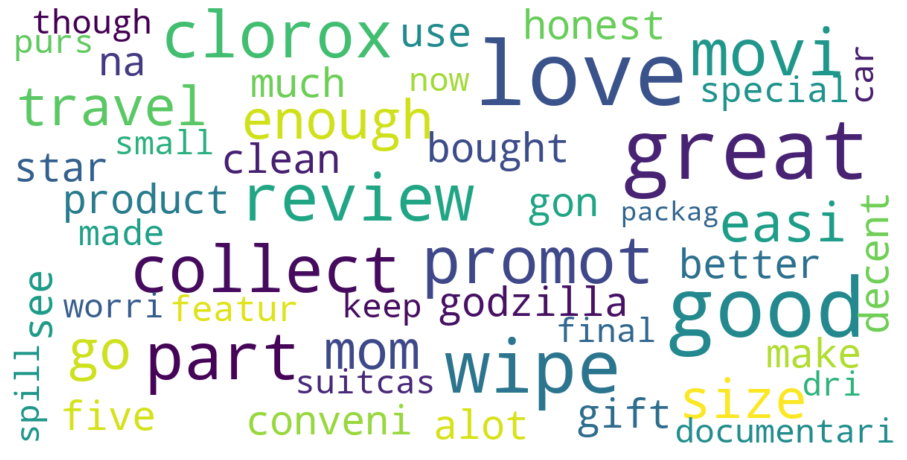

In [27]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=50, max_font_size=40,
                     scale=3, random_state=1).generate(str(dataP['review_title_text'].value_counts()))
plt.figure(figsize=(16,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Observations:**

    - WordCount check after text processing, shows our stemming and lemmi has worked fine.

### Split Data - Train and Test

In [28]:
reviews = dataP['review_title_text']
y = dataP['user_sentiment']

In [29]:
### SPlit Data - Train and Test
text_train, text_test, y_train, y_test = train_test_split(reviews, y, test_size=0.3, random_state=1001)
vectorizer = TfidfVectorizer(stop_words='english',min_df=0.005,ngram_range=(1,2))
X_train = vectorizer.fit_transform(text_train)
X_test = vectorizer.transform(text_test)

In [30]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(21000, 645)
(21000,)
(9000, 645)
(9000,)


### Class Imabalance Check

In [31]:
print("Count of label Positive: " , sum(y_train==1))
print("Count of label Negative: " , sum(y_train==0))
print("Ratio (%) "  , sum(y_train==1)/len(y_train)*100)

Count of label Positive:  18678
Count of label Negative:  2322
Ratio (%)  88.94285714285715


We can see that the data is highly imbalanced. We will use SMOTE to address 

__SMOTE - Synthetic Minority Oversampling Technique__

SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

We will keep the raw imbalanced data too to check the advantage/effect of SMOTE

In [32]:
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
#help(SMOTE)
print("After SMOTE, counts of label Positive: " , sum(y_train_sm==1))
print("After SMOTE, counts of label Negative: " , sum(y_train_sm==0))
print("After SMOTE, Ratio (%) "  , sum(y_train_sm==1)/len(y_train_sm)*100)

After SMOTE, counts of label Positive:  18678
After SMOTE, counts of label Negative:  18678
After SMOTE, Ratio (%)  50.0


### Common Functions

- Common functions to help train and collate different models.
- We are also defining something called model_data, this is to tabulate different model performances for analysis purpose only.

In [33]:
# Create a dataframe to hodel model information.
def setmodeldata():
    columns = {' Model Name ':[],' Accuracy ':[],' Mean ROC AUC ':[],' Precision ':[], 
               ' Recall ':[],' F1 Score ':[],}
    model_data = pd.DataFrame(columns)
    return model_data
    
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Function to fit and predict the model performance.
def process_model(title, model, X, y):
    model.fit(X,y)
    test_pred = model.predict(X_test)
    accuracy = accuracy_score(test_pred,y_test)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    p, r, f, s = precision_recall_fscore_support(y_test, test_pred, labels=None, pos_label=1, average="macro")
    accuracy = round(accuracy*100,2)
    precision = round(p*100,2)
    recall = round(r*100,2)
    f1_score = round(f*100,2)
    auc_score  = round(np.mean(scores),3)
    print("Accuracy     :", accuracy, "%")
    print("Precision    :", precision, "%")
    print("Recall       :", recall, "%")
    print("F1 Score     :", f1_score, "%")
    print("Mean ROC AUC :",  auc_score)
    value = {' Model Name ': title,' Accuracy ': accuracy,' Mean ROC AUC ':auc_score,
           ' Precision ':precision, ' Recall ':recall,' F1 Score ':f1_score}
    return value

# Function to process HTP models, avoid going into kFold again, we can calculate test score from cv_results.
def process_model_HP(title, model):
    means = rf_model_HPT.cv_results_['mean_test_score']
    pred_HPT = model.predict(X_test)
    accuracy = accuracy_score(pred_HPT,y_test)
    p, r, f, s = precision_recall_fscore_support(y_test, pred_HPT, labels=None, pos_label=1, average="macro")
    accuracy = round(accuracy*100,2)
    precision = round(p*100,2)
    recall = round(r*100,2)
    f1_score = round(f*100,2)
    auc_score  = round(np.amax(means),3)
    print("Accuracy     :", accuracy, "%")
    print("Precision    :", precision, "%")
    print("Recall       :", recall, "%")
    print("F1 Score     :", f1_score, "%")
    print("Mean ROC AUC :", auc_score)
    value = {' Model Name ': title,' Accuracy ': accuracy,' Mean ROC AUC ':auc_score,
           ' Precision ':precision, ' Recall ':recall,' F1 Score ':f1_score}
    return value    

### Logistic Regression

In [34]:
# RAW Data Set
model_data = setmodeldata()
lr_model_raw = LogisticRegression(C=5, max_iter=200, class_weight='balanced')
df = process_model('Logistic Regression (Raw)', lr_model_raw, X_train, y_train)
model_data = model_data.append(df,ignore_index=True)

Accuracy     : 83.07 %
Precision    : 67.94 %
Recall       : 81.86 %
F1 Score     : 71.05 %
Mean ROC AUC : 0.899


In [35]:
# SMOTE Blanaced Set.
lr_model = LogisticRegression(C=5, max_iter=200)
df = process_model('Logistic Regression (Balanced)', lr_model, X_train_sm, y_train_sm)
model_data = model_data.append(df,ignore_index=True)

Accuracy     : 86.64 %
Precision    : 70.57 %
Recall       : 79.93 %
F1 Score     : 73.73 %
Mean ROC AUC : 0.959


### Random Forest

In [36]:
# RAW Data Set
rf_model_raw = RandomForestClassifier(class_weight='balanced',n_estimators=200, max_depth=4, random_state=42, n_jobs=-1)
df= process_model('Random Forest (Raw)', rf_model_raw, X_train, y_train)
model_data = model_data.append(df,ignore_index=True)

Accuracy     : 75.77 %
Precision    : 63.17 %
Recall       : 77.52 %
F1 Score     : 63.96 %
Mean ROC AUC : 0.839


In [37]:
# SMOTE Blanaced Set.
rf_model = RandomForestClassifier(random_state=42,n_jobs=-1)
df = process_model('Random Forest (Balanced)', rf_model, X_train_sm, y_train_sm)
model_data = model_data.append(df,ignore_index=True)

Accuracy     : 90.42 %
Precision    : 77.01 %
Recall       : 73.43 %
F1 Score     : 75.03 %
Mean ROC AUC : 0.994


In [38]:
# HPT Processing over SMOTE Blanaced data. 
params = {  
    "n_estimators": st.randint(3, 200),
    "max_depth": st.randint(3, 100),
    "min_samples_leaf": [1, 2, 3, 4, 5]
}
folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
rf_model_HPT  = RandomizedSearchCV(rf_model, params, n_jobs=-1, cv=folds, verbose=1)
rf_model_HPT.fit(X_train_sm, y_train_sm)

print("Best Score: ", rf_model_HPT.best_score_)
print("Best hyperparameters: ", rf_model_HPT.best_params_,"\n\n") 
print("")
df = process_model_HP("Random Forest (HPT)",rf_model_HPT )
model_data = model_data.append(df,ignore_index=True)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Best Score:  0.960568369122457
Best hyperparameters:  {'max_depth': 96, 'min_samples_leaf': 1, 'n_estimators': 158} 



Accuracy     : 90.27 %
Precision    : 76.47 %
Recall       : 73.92 %
F1 Score     : 75.1 %
Mean ROC AUC : 0.961


### XGBoost

In [39]:
# RAW Data Set
xg_model_raw = XGBClassifier(random_state=42,scale_pos_weight=88)
df = process_model('XGBoost (Raw)', xg_model_raw, X_train, y_train)
model_data = model_data.append(df,ignore_index=True)

Accuracy     : 88.97 %
Precision    : 87.07 %
Recall       : 52.95 %
F1 Score     : 52.69 %
Mean ROC AUC : 0.884


In [40]:
# SMOTE Blanaced Set.
xg_model = XGBClassifier(random_state=42)
df = process_model('XGBoost (Balanced)', xg_model, X_train_sm, y_train_sm)
model_data = model_data.append(df,ignore_index=True)

Accuracy     : 87.49 %
Precision    : 70.94 %
Recall       : 76.51 %
F1 Score     : 73.18 %
Mean ROC AUC : 0.974


In [41]:
# HPT Processing over SMOTE Blanaced data. 
params = {  
    "n_estimators": st.randint(3, 100),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "gamma": st.uniform(0, 10)
}
folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
xg_model_HPT  = RandomizedSearchCV(xg_model, params, n_jobs=-1, cv=folds, verbose=1)
xg_model_HPT.fit(X_train_sm, y_train_sm)

print("\n\nBest Score: ", xg_model_HPT.best_score_)
print("Best hyperparameters: ", xg_model_HPT.best_params_,"\n\n") 
df = process_model_HP("XGBoost (HPT)",xg_model_HPT )
model_data = model_data.append(df,ignore_index=True)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished




Best Score:  0.9438373551307299
Best hyperparameters:  {'gamma': 1.3818627709969489, 'learning_rate': 0.4065457326603664, 'max_depth': 24, 'n_estimators': 30} 


Accuracy     : 89.4 %
Precision    : 74.22 %
Recall       : 75.26 %
F1 Score     : 74.72 %
Mean ROC AUC : 0.961


### Naive Bayes

In [42]:
# RAW Data Set
nb_model_raw = MultinomialNB()
df = process_model('Naive Bayes (Raw)', nb_model_raw, X_train, y_train)
model_data = model_data.append(df,ignore_index=True)

Accuracy     : 88.49 %
Precision    : 70.73 %
Recall       : 54.75 %
F1 Score     : 55.86 %
Mean ROC AUC : 0.824


In [43]:
# SMOTE Blanaced Set.
nb_model = MultinomialNB()
df = process_model('Naive Bayes (Balanced)', nb_model, X_train_sm, y_train_sm)
model_data = model_data.append(df,ignore_index=True)

Accuracy     : 80.91 %
Precision    : 64.56 %
Recall       : 75.36 %
F1 Score     : 66.88 %
Mean ROC AUC : 0.855


### Model Selection

Let us see the performance of each model

In [44]:
display(model_data)

,Model Name,Accuracy,Mean ROC AUC,Precision,Recall,F1 Score
0,Logistic Regression (Raw),83.07,0.899,67.94,81.86,71.05
1,Logistic Regression (Balanced),86.64,0.959,70.57,79.93,73.73
2,Random Forest (Raw),75.77,0.839,63.17,77.52,63.96
3,Random Forest (Balanced),90.42,0.994,77.01,73.43,75.03
4,Random Forest (HPT),90.27,0.961,76.47,73.92,75.10
5,XGBoost (Raw),88.97,0.884,87.07,52.95,52.69
6,XGBoost (Balanced),87.49,0.974,70.94,76.51,73.18
7,XGBoost (HPT),89.40,0.961,74.22,75.26,74.72
8,Naive Bayes (Raw),88.49,0.824,70.73,54.75,55.86
9,Naive Bayes (Balanced),80.91,0.855,64.56,75.36,66.88


### Observations:

- We can see that most of the models gives decent accuracy, certain models gives a bad score of precision, recall and F1 score. 
- SMOTE imablance handling did improve the overall performance of each model. 
- I am selecting __Random Forest Balanced__ as my final model, mainly coz of a balanced value for accuracy, roc & F1 with decent values for precision and recall.


**Saving selected model and the vectorizer**

In [45]:
# Save the model as a pickle in a file 
joblib.dump(rf_model, 'models/rf_model.pkl') 
joblib.dump(vectorizer, 'models/vectorizer.pkl') 

['models/vectorizer.pkl']

## Building a Recommendation System 

- User based recommendation
- User based prediction & evaluation
- Item based recommendation
- Item based prediction & evaluation

In [46]:
# import libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances

In [47]:
#Read the input files.
ratings = pd.read_csv("sample30.csv", encoding='ISO-8859-1', low_memory=False)
ratings.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


### Data Check : Let us keep the data required and ignore others.

In [48]:
ratings['review_title_text'] = ratings['reviews_title'].map(str) + ' ' + ratings['reviews_text'].map(str)
useful_list = ['id','name','reviews_username','reviews_rating', 'review_title_text', 'manufacturer' , 'categories']
ratings = ratings[useful_list]
ratings.head(5)

,id,name,reviews_username,reviews_rating,review_title_text,manufacturer,categories
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5,Just Awesome i love this album. it's very good...,Universal Music Group / Cash Money,"Movies, Music & Books,Music,R&b,Movies & TV,Mo..."
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5,Good Good flavor. This review was collected as...,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co..."
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5,Good Good flavor.,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co..."
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,rebecca,1,Disappointed I read through the reviews on her...,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm..."
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,walker557,1,Irritation My husband bought this gel for us. ...,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm..."


In [49]:
ratings['reviews_rating'].unique()

array([5, 1, 3, 4, 2])

## Dividing the dataset into train and test

In [50]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.30, random_state=42)
print(train.shape)
print(test.shape)

(21000, 7)
(9000, 7)


In [51]:
# Pivot the train ratings' dataset into matrix format in which columns are products and the rows are user name.
df_pivot = train.pivot_table(index='reviews_username', columns='id',values='reviews_rating').fillna(0)
df_pivot.sample(10)



id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,...,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
johnnybleach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bestbuy10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [52]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [53]:
dummy_train.sample(5)

,id,name,reviews_username,reviews_rating,review_title_text,manufacturer,categories
5692,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),actionaction,4,Fun and exciting The mixture of the cast and t...,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh..."
4301,AVpe9W4D1cnluZ0-avf0,Hoover174 Platinum Collection153 Lightweight B...,kanakana,5,"Great, I LOVE it! Very light and strong. Wish ...",Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri..."
19359,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,sallysue0827,5,Mrs. I recommend this product to everyone! I t...,AmazonUs/CLOO7,"Household Chemicals,Household Cleaners,Bath & ..."
23739,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,sweetee,4,Great DVD Waiting a long time for this DVD. Gr...,Test,"Movies, Music & Books,Movies,Action & Adventur..."
19579,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,christina1001,5,Portable and convenient I keep a carton in our...,AmazonUs/CLOO7,"Household Chemicals,Household Cleaners,Bath & ..."


In [54]:
# The movies not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [55]:
dummy_train['reviews_username'].nunique()

18213

In [56]:
dummy_train = dummy_train.pivot_table(index='reviews_username', columns='id',values='reviews_rating').fillna(1)
dummy_train.sample(5)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,...,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
virgo14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
laura83,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

# User Similarity Matrix

## Using Cosine Similarity

In [57]:
df_pivot.index.nunique()

18213

In [58]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


## Using Adjusted Cosine 

### Here, we are not removing the NaN values and calculating the mean only for the movies rated by the user

In [59]:
# Create a user-product matrix.
df_pivot = train.pivot_table(index='reviews_username', columns='id',values='reviews_rating')
df_pivot.sample(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,...,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
pyst,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cdearle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [60]:
mean = np.nanmean(df_pivot, axis=1)
mean

array([4., 3., 3., ..., 5., 5., 2.])

In [61]:
df_subtracted = (df_pivot.T - mean).T
df_subtracted

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,...,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [62]:
df_subtracted = df_subtracted.fillna(0)
df_subtracted

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,...,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [63]:
user_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
user_correlation.shape

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


(18213, 18213)

### Normalising the rating of the movie for each user around 0 mean

## Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [64]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

Rating predicted by the user (for movies rated as well as not rated) is the weighted sum of correlation with the movie rating (as present in the rating dataset). 

In [65]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.39045722, ..., 1.81848242, 0.        ,
        0.        ],
       ...,
       [2.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.53553391, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.53553391, 0.        ,
        0.        ]])

In [66]:
user_predicted_ratings.shape

(18213, 253)

In [67]:
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.39045722, ..., 1.81848242, 0.        ,
        0.        ],
       ...,
       [2.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.53553391, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.53553391, 0.        ,
        0.        ]])

Since we are interested only in the movies not rated by the user, we will ignore the movies rated by the user by making it zero. 

In [68]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
# Lets check some rows with non zero values to confirm. 
user_final_rating[(user_final_rating.select_dtypes(include=['number']) != 0).any(1)]

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,...,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,3.535534,0.0,0.0,0.000000,0.000000,2.076137,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.660910,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00

In [69]:
d = user_final_rating.loc['abbey'].sort_values(ascending=False)[0:20]
d

id
AVpf3VOfilAPnD_xjpun    950.640120
AVpfPaoqLJeJML435Xk9     25.988820
AVpf63aJLJeJML43F__Q     17.641026
AVpe8gsILJeJML43y6Ed     16.667570
AVpe41TqilAPnD_xQH3d     15.835834
AVpe59io1cnluZ0-ZgDU     12.836525
AVpfM_ytilAPnD_xXIJb     12.806906
AVpf0eb2LJeJML43EVSt     12.088760
AVpf5olc1cnluZ0-tPrO      9.202609
AVpfRTh1ilAPnD_xYic2      6.308505
AVpe9W4D1cnluZ0-avf0      5.695258
AVpf2tw1ilAPnD_xjflC      5.694904
AV1YGDqsGV-KLJ3adc-O      4.580876
AVpfPnrU1cnluZ0-g9rL      3.988858
AVpfRoqcLJeJML436FqG      3.928595
AVpfR5m0LJeJML436K3W      3.672271
AVpf385g1cnluZ0-s0_t      3.632047
AVpfBpnEilAPnD_xTUBx      3.570244
AV1Yn94nvKc47QAVgtst      3.512957
AVpfBU2S1cnluZ0-cJsO      3.505583
Name: abbey, dtype: float64

### Map with Product Title and other fields. 

In [70]:
d = pd.merge(d,ratings,left_on='id',right_on='id', how = 'left')
d.sample(5)

,id,abbey,name,reviews_username,reviews_rating,review_title_text,manufacturer,categories
5029,AVpf3VOfilAPnD_xjpun,950.640120,Clorox Disinfecting Wipes Value Pack Scented 1...,jennifer23453,5,Great product! Easy to use Use every day... Ea...,Clorox,"Household Essentials,Cleaning Supplies,Kitchen..."
3039,AVpf3VOfilAPnD_xjpun,950.640120,Clorox Disinfecting Wipes Value Pack Scented 1...,tiffy8224,5,"In Love I use it all over my home,for everythi...",Clorox,"Household Essentials,Cleaning Supplies,Kitchen..."
15839,AVpfRTh1ilAPnD_xYic2,6.308505,Planes: Fire Rescue (2 Discs) (includes Digita...,wethree,4,Decent follow up to original All the Cars and ...,Walt Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa..."
9815,AVpfPaoqLJeJML435Xk9,25.988820,Godzilla 3d Includes Digital Copy Ultraviolet ...,peanut,4,King of Monsters Liked the view story was told...,Test,"Movies, Music & Books,Movies,Action & Adventur..."
7482,AVpf3VOfilAPnD_xjpun,950.640120,Clorox Disinfecting Wipes Value Pack Scented 1...,tina71,5,Wonderful Cleansing Wipes for the Bathroom Qui...,Clorox,"Household Essentials,Cleaning Supplies,Kitchen..."


# Evaluation - User User 

Evaluation will be same - The  difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user. 

In [71]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape
common.sample(5)

,id,name,reviews_username,reviews_rating,review_title_text,manufacturer,categories
20818,AVpfLnfPLJeJML434HpK,"Pleasant Hearth 1,800 sq ft Wood Burning Stove...",redbeard1,4,good looking and easy to use my vermont castin...,"GHP Group, Inc.","Home Improvement,Heating, Cooling, & Air Quali..."
29602,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,jboogie212,4,Great Value And Quality I used this product fo...,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday..."
8299,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,sil2006,5,Best Product Feel safe using this product. Ove...,Clorox,"Household Essentials,Cleaning Supplies,Kitchen..."
7952,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,gabby20,5,Easy To Clean With I love this spray I use it ...,Clorox,"Household Essentials,Cleaning Supplies,Kitchen..."
8835,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,thebeast13,5,Great Product It works. They clean up any mess...,Clorox,"Household Essentials,Cleaning Supplies,Kitchen..."


In [72]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
common_user_based_matrix.sample(5)

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfiUrfLJeJML43-9nY,AVpfkIiYilAPnD_xeEjr,AVpfl6sF1cnluZ0-nmwC,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bakie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
raul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cowboy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [73]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,...,18138,18139,18140,18141,18142,18143,18144,18145,18146,18147,18148,18149,18150,18151,18152,18153,18154,18155,18156,18157,18158,18159,18160,18161,18162,18163,18164,18165,18166,18167,18168,18169,18170,18171,18172,18173,18174,18175,18176,18177,18178,18179,18180,18181,18182,18183,18184,18185,18186,18187,18188,18189,18190,18191,18192,18193,18194,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211,18212
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624695,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.707107,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.514496,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.6,0.000000,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.707107,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.514496,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.6,0.000000,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.707107,1.0,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.624695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.707107,1.0,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.

In [74]:
df_subtracted.head(1)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,...,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,...,18138,18139,18140,18141,18142,18143,18144,18145,18146,18147,18148,18149,18150,18151,18152,18153,18154,18155,18156,18157,18158,18159,18160,18161,18162,18163,18164,18165,18166,18167,18168,18169,18170,18171,18172,18173,18174,18175,18176,18177,18178,18179,18180,18181,18182,18183,18184,18185,18186,18187,18188,18189,18190,18191,18192,18193,18194,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211,18212
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
dee0581,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
milisa40,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.707107,1.000000,0.0,0.000000,0.0,1.000000,1.000000,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,...,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.624695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
techgeek85,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
kikaimiku,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

In [76]:
common.head(1)

,id,name,reviews_username,reviews_rating,review_title_text,manufacturer,categories
2308,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),iplsports,5,Awesome movie! I have to admit that I was skep...,Twentieth Century Fox,"Movies & TV Shows,Movies,Romance,Romantic Come..."


In [77]:
list_name = common.reviews_username.tolist()
user_correlation_df.columns = df_subtracted.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape

(1684, 18213)

In [78]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_2.shape

(1684, 1684)

In [79]:
user_correlation_df_3 = user_correlation_df_2.T
print(user_correlation_df_3.shape)
user_correlation_df_3.head(5)

(1684, 1684)


,00sab00,1234,143st,23jen,4 rooms 1 dog lotsa fur,4djs,7.87E+11,7inthenest,85lisa,8ellie24,aac06002,abby,abc,abcdef,abcssds,abigail,abret,ace24,acellacey,actionaction,adam,adriana,adrienne,ael26,afooey,afwifey2003,agmt,ah78,aj1135,aj2012,ajay,ajeff,ajune,aktcharlotte,alex,alexis,ali1353,alice,ally,alredhouse,alta,aluns,amanda,amanda01,amanda13,amandamueller,amazing,amber,amcomber,ami35,amishmom,amlyke,ammcam,amyrn,amyw333,ana79,andi,andie,andrea,andreafl,andream82,andrew,andy,angel,angel65481,angela,angie,angie0104,angie2,angie447,angiesmessykids,anna,anna0087,anne,annie,...,tracelyn28,tracie,treese,treesmith,trice,trichmond,trish626,trisha,trisha27,trix,truckinbarbie,truth,tshortt,ttdebbi,turi,turtleboy,tw350z,twin,unhappy cus to mer,unicorn351,val214,valentinebarrera,valerie,valerie1981,valery,vccaan,vicki,vickie,vickie49464,vicocious,victoria,viewer,viper,vivian,vlo910,voxemluth,vyph,vypkf0,walker,weewee,wendy,whome,whythis,wildman,willy,wind,windowkitty,wiseman378,wizard,wolfie,wolvarine,wonster67,woohoo,woottos,workingmomof1,wvshopaholic,xavier,xlivayy,xmom,yamel97,yayawomack,yazzmiin,yellow,yeya,ygtz,yoadrian,yorkielvr,yucky111,yummy,yvonne,zach,zburt5,zebras,zipper,zippy
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.447214,0.0,0.0,0.500000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1234,0.0,1.000000,0.0,0.707107,0.0,0.707107,0.0,0.707107,0.707107,0.707107,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.707107,0.0,0.335432,0.0,0.0,0.0,0.707107,0.707107,0.0,0.707107,0.0,0.707107,0.0,0.0,0.707107,0.707107,0.326036,0.370625,0.0,0.0,0.353553,0.707107,0.0,0.707107,0.408248,0.0,0.0,0.0,0.348155,0.0,0.707107,0.707107,0.0,0.707107,0.707107,0.0,0.707107,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.707107,0.408248,0.316228,0.0,0.0,0.565685,0.707107,0.0,0.0,0.707107,0.500000,0.707107,0.353553,0.0,...,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.707107,0.0,0.707107,0.707107,0.183254,0.0,0.707107,0.707107,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.5,0.0,0.707107,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.707107,0.707107,0.0,0.441726,0.0,0.707107,0.0,0.0,0.0,0.707107,0.707107,0.707107,0.707107,0.707107,0.0,0.0,0.707107,0.0,0.0,0.707107,0.0,0.424264
143st,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.447214,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.431934,0.0,0.000000,0.000000,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.

In [80]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[ 0.        ,  6.85485666,  0.        , ...,  1.85485666,
         2.38365647,  1.        ],
       [ 3.10190162, 12.18125214,  0.        , ...,  1.18042355,
         0.        ,  3.53553391],
       [ 0.        ,  4.2334935 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5       ,  5.60711455,  0.        , ...,  0.        ,
         0.        ,  5.        ],
       [ 0.        ,  4.2334935 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.33205081,  6.97186646,  0.        , ...,  1.0016226 ,
         0.        ,  0.        ]])

In [81]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [82]:
dummy_test.shape

(1684, 124)

In [83]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfiUrfLJeJML43-9nY,AVpfkIiYilAPnD_xeEjr,AVpfl6sF1cnluZ0-nmwC,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [84]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfiUrfLJeJML43-9nY,AVpfkIiYilAPnD_xeEjr,AVpfl6sF1cnluZ0-nmwC,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [85]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfiUrfLJeJML43-9nY,AVpfkIiYilAPnD_xeEjr,AVpfl6sF1cnluZ0-nmwC,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.717711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.060271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.93637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,

In [86]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [87]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [88]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [89]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.132919268808573


## Using Item similarity

# Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user instead of each movie. 

In [90]:
df_pivot = train.pivot_table(index='reviews_username', columns='id',
               values='reviews_rating').T

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234567,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,132457,13ld,13thfaerie,143st,15425shopper,1616,1753,17roses,1863philly,1943,1970,1979edes,1992firebirdgirl,19bubba67,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1gra,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jodie,1movielover2,1nikki31t,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1stcavdivision,1stgrade,1sungirl,1texasmom,1tomg,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2016parker10,2062351337,20crafter16,2175046722,21please,232323,23jen,...,zach,zacharymcneill,zachizz,zachsmom,zaibo,zak,zak08,zakkzakk,zamanda,zanarkandruinsx2,zanay,zapaduh,zapman,zara0215,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zee74,zegan,zenanuts,zeramm,zero,zetamom,zfem2,zhjwpp,zhynellebb,zibby4,zillanator,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoeellasca,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zotox,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zxjki
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,

Normalising the movie rating for each movie for using the Adujsted Cosine

In [91]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [92]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234567,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,132457,13ld,13thfaerie,143st,15425shopper,1616,1753,17roses,1863philly,1943,1970,1979edes,1992firebirdgirl,19bubba67,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1gra,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jodie,1movielover2,1nikki31t,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1stcavdivision,1stgrade,1sungirl,1texasmom,1tomg,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2016parker10,2062351337,20crafter16,2175046722,21please,232323,23jen,...,zach,zacharymcneill,zachizz,zachsmom,zaibo,zak,zak08,zakkzakk,zamanda,zanarkandruinsx2,zanay,zapaduh,zapman,zara0215,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zee74,zegan,zenanuts,zeramm,zero,zetamom,zfem2,zhjwpp,zhynellebb,zibby4,zillanator,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoeellasca,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zotox,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zxjki
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.813278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN

Finding the cosine similarity using pairwise distances approach

In [93]:
from sklearn.metrics.pairwise import pairwise_distances

In [94]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [95]:
item_correlation.shape

(253, 253)

Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [96]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Prediction - Item Item

In [97]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00133473, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00053389, 0.        ,
        0.        ]])

In [98]:
item_predicted_ratings.shape

(18213, 253)

In [99]:
dummy_train.shape

(18213, 253)

### Filtering the rating only for the movies not rated by the user for recommendation

In [100]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,...,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.024373,0.0,0.0,0.000000,0.000000,0.020659,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### Finding the top 5 recommendation for the *user*



In [101]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc['josh'].sort_values(ascending=False)[0:20]
d

id
AVpe4pnBilAPnD_xQDeb    0.268582
AVpf5olc1cnluZ0-tPrO    0.221372
AVpfozgyilAPnD_xfe0r    0.127825
AVpe59io1cnluZ0-ZgDU    0.116848
AVpfQtEm1cnluZ0-hUpe    0.108024
AVpfJcHuLJeJML433ZrY    0.077183
AVpfRTh1ilAPnD_xYic2    0.074299
AVpfPx6V1cnluZ0-hA5y    0.070285
AVpfkQkcLJeJML43_kEC    0.058470
AVpe_5U_ilAPnD_xSrxG    0.058470
AVpfE7puilAPnD_xUcCW    0.054617
AVpfPnrU1cnluZ0-g9rL    0.052228
AVpfOmKwLJeJML435GM7    0.052207
AVpfthSailAPnD_xg3ON    0.048313
AVpf0thK1cnluZ0-r8vR    0.047108
AVpfEqruilAPnD_xUWDr    0.044206
AVpfGuDrLJeJML432fDz    0.043177
AVpfM_ytilAPnD_xXIJb    0.038094
AVpf0eb2LJeJML43EVSt    0.036584
AVpfBrUZilAPnD_xTUly    0.035138
Name: josh, dtype: float64

In [102]:
d = pd.merge(d,ratings,left_on='id',right_on='id',how = 'left')
d.head()
d.shape

(4071, 8)

In [103]:
train_new = pd.merge(train,ratings,left_on='id',right_on='id',how='left')
train_new.head()

,id,name_x,reviews_username_x,reviews_rating_x,review_title_text_x,manufacturer_x,categories_x,name_y,reviews_username_y,reviews_rating_y,review_title_text_y,manufacturer_y,categories_y
0,AVpftikC1cnluZ0-p31V,"Storkcraft Tuscany Glider and Ottoman, Beige C...",1derpet1,2,great at first and then... The chair was easy ...,1200,"Baby,Nursery & Decor,Furniture,Rocking Chairs,...","Storkcraft Tuscany Glider and Ottoman, Beige C...",keira1,1,"If you have a baby, You will regret it If you ...",1200,"Baby,Nursery & Decor,Furniture,Rocking Chairs,..."
1,AVpftikC1cnluZ0-p31V,"Storkcraft Tuscany Glider and Ottoman, Beige C...",1derpet1,2,great at first and then... The chair was easy ...,1200,"Baby,Nursery & Decor,Furniture,Rocking Chairs,...","Storkcraft Tuscany Glider and Ottoman, Beige C...",15425shopper,1,Incomplete The glider came incomplete as the a...,1200,"Baby,Nursery & Decor,Furniture,Rocking Chairs,..."
2,AVpftikC1cnluZ0-p31V,"Storkcraft Tuscany Glider and Ottoman, Beige C...",1derpet1,2,great at first and then... The chair was easy ...,1200,"Baby,Nursery & Decor,Furniture,Rocking Chairs,...","Storkcraft Tuscany Glider and Ottoman, Beige C...",kb143k,1,DO NOT BUY! Itchy cushions! I purchased this g...,1200,"Baby,Nursery & Decor,Furniture,Rocking Chairs,..."
3,AVpftikC1cnluZ0-p31V,"Storkcraft Tuscany Glider and Ottoman, Beige C...",1derpet1,2,great at first and then... The chair was easy ...,1200,"Baby,Nursery & Decor,Furniture,Rocking Chairs,...","Storkcraft Tuscany Glider and Ottoman, Beige C...",truth,1,JUNK - DONT BUY - AVOID Avoid this product. Ve...,1200,"Baby,Nursery & Decor,Furniture,Rocking Chairs,..."
4,AVpftikC1cnluZ0-p31V,"Storkcraft Tuscany Glider and Ottoman, Beige C...",1derpet1,2,great at first and then... The chair was easy ...,1200,"Baby,Nursery & Decor,Furniture,Rocking Chairs,...","Storkcraft Tuscany Glider and Ottoman, Beige C...",stacy02,1,Waste of Money Within weeks of using this rock...,1200,"Baby,Nursery & Decor,Furniture,Rocking Chairs,..."


# Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user. 

In [104]:
test.columns

Index(['id', 'name', 'reviews_username', 'reviews_rating', 'review_title_text',
       'manufacturer', 'categories'],
      dtype='object')

In [105]:
common =  test[test.id.isin(train.id)]
common.shape

(8980, 7)

In [106]:
common.head(4)

,id,name,reviews_username,reviews_rating,review_title_text,manufacturer,categories
2308,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),iplsports,5,Awesome movie! I have to admit that I was skep...,Twentieth Century Fox,"Movies & TV Shows,Movies,Romance,Romantic Come..."
22404,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishi...,crysv,1,Such a waste....! I use to LOVE Clear... until...,Clear,"Personal Care,Hair Care,Shampoo,Featured Brand..."
23397,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,sammhc12,4,A page from the old school Godzilla I enjoyed ...,Test,"Movies, Music & Books,Movies,Action & Adventur..."
25058,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,spyder,5,awesome fx SPECIAL FX ARE JUST WAY OVER THE TO...,Test,"Movies, Music & Books,Movies,Action & Adventur..."


In [107]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [108]:
common_item_based_matrix.shape

(196, 8366)

In [109]:
item_correlation_df = pd.DataFrame(item_correlation)

In [110]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,...,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,...,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.017764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001949,0.0,0.0,0.0,0.0,0.002813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007052,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003222,0.0,0.0,0.0,0.021063,0.0,0.0,0.0,0.0,0.00143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002009,0.00177,0.0,0.0,0.0,0.0,0.069843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0

In [112]:
list_name = common.id.tolist()

In [113]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [114]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [115]:
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,...,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.017764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0

In [116]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.00000000e+00, ...,
        0.00000000e+00, 9.74507569e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.33473243e-03, 0.00000000e+00, 1.06778595e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [117]:
common_item_predicted_ratings.shape

(196, 8366)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train



In [118]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.


In [119]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [120]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [121]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [122]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5698477915577103


### Observations:


- User-based recommendation system  - RMSE  ~ 
- Item-based recommendation system  - RMSE  ~ 

- In this scenaro, we have lower RMSE for User-User system. So we going to select it. In short the recomendation will work based on the correlation between users. If the user is highly correlated with user B, then we will select the product from User B( excluding the ones already reviewd by User A), and so on and so on from other users with decreasing order of correlation. 

**Saving selected model**

In [123]:
# Save the model as a pickle in a file 
joblib.dump(user_final_rating, 'models/user_user.pkl') 

['models/user_user.pkl']

### Testing 

- Below part of code was to test the interaction between models and how we fetch it. The final solution is in the main.py file in deployment, it will be updated version.

In [124]:
model = joblib.load('models/user_user.pkl') 

In [125]:
## List top 20 products for Mr Josh
fr = model.loc['josh'].sort_values(ascending=False)[0:20]
fr

id
AVpfRTh1ilAPnD_xYic2    128.844179
AVpf0eb2LJeJML43EVSt    110.220921
AVpe59io1cnluZ0-ZgDU     79.240721
AVpf2tw1ilAPnD_xjflC     69.875272
AVpf3VOfilAPnD_xjpun     51.731863
AVpfJP1C1cnluZ0-e3Xy     33.612724
AVpfM_ytilAPnD_xXIJb     26.427573
AVpfR5m0LJeJML436K3W     25.026041
AVpf5olc1cnluZ0-tPrO     23.610163
AVpf0thK1cnluZ0-r8vR     19.649547
AV1YGDqsGV-KLJ3adc-O     19.105493
AVpfPnrU1cnluZ0-g9rL     19.061915
AVpe31o71cnluZ0-YrSD     18.529798
AVpe8gsILJeJML43y6Ed     18.125213
AVpf63aJLJeJML43F__Q     16.374961
AVpfazX31cnluZ0-kbdl     12.519180
AVpf385g1cnluZ0-s0_t     11.892797
AVpfOmKwLJeJML435GM7     10.788180
AVpfD9xTLJeJML431ig2     10.699278
AVpfN6Z71cnluZ0-gZmO     10.241717
Name: josh, dtype: float64

In [126]:
## Function to get Info.
def get_info(id):
    dat = dataP[dataP.id == id]
    pos_per = calculate_top(dat)
    return {'name': dat['name'].unique()[0] , 'pos_percent':pos_per }

def calculate_top(test):    
    output = rf_model.predict(vectorizer.transform(test['review_title_text']))
    pos= 0
    neg = 0
    for out in output:
        if out == 1:
            pos = pos + 1
        else:
            neg = neg + 1
    return round((pos/(pos+neg))*100,2)
     

In [129]:
cl = {'name':[],'pos_percent':[]}
op = pd.DataFrame(cl)
for id in fr.index:
    value = get_info(id)
    op = op.append(value,ignore_index=True)
## Sort by positive percent and then by name.
op.sort_values(by=['pos_percent', 'name'], ascending=[False, True]).iloc[:5, :]

,name,pos_percent
11,Stargate (ws) (ultimate Edition) (director's C...,96.24
2,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,95.96
3,Red (special Edition) (dvdvideo),95.09
9,100:Complete First Season (blu-Ray),94.96
0,Planes: Fire Rescue (2 Discs) (includes Digita...,94.14


**Conclusion:**
    
   - The models seems to work fine and am able to get the top 5 products.
   - We have selected the Ramdom Forest (SMOTE) for Sentiment Analysis. 
   - For Recommendation System, we selected User-User Model.
    
  The code is deployed in Heroku, following notes for clarity of process followed: 
  
  - Using preprocess.py file to load pickles and data during startup itself.
  - model.py contains logic for using the models to get the desired output. 
  - app.py file contains the API and methods to integrate with UI. 
  - User input case validation is done, converting to lowercase before passing to model. 
  - Broader, eventhough not ideal exception handling is done to avoid discrepencies. 
  - An API is also provided to see the json data. 
  
  Heroku URL: https://capstone-sentiment.herokuapp.com
    
